<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/Deep%20Learning/MIT%20Lectures/Recurrent%20Neural%20Networks/RNN_MusicGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet_ml > /dev/null 2>&1
!apt-get install abcmidi timidity > /dev/null 2>&1
!pip install mitdeeplearning --quiet

import comet_ml
import tensorflow as tf
import mitdeeplearning as mdl
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
import regex as re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#Data Processing

cwd = os.getcwd() #Currently Working Directory

with open(os.path.join(cwd, "irish.abc"), "r") as f:
  text = f.read()

pattern = '(^|\n\n)(.*?)\n\n' #(possible starting of text: ^ start of a string, \n\n)(. is any single character except \n, * zero or more times, ? shortest possible sequence)
search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
songs = [song[1] for song in search_results]

songs_joined = "\n\n".join(songs)
unique = sorted(set(songs_joined))

#Numerical Respresentation of text
char2idx = {u:i for i, u in enumerate(unique)}
idx2char = np.array(unique)
vectorized = np.array([char2idx[c] for c in songs_joined])

In [ ]:
def get_batch(vectorized, seq_length, batch_size):
  n = len(vectorized) - 1
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized[i:i+seq_length] for i in idx]
  target_batch = [vectorized[i+1:i+seq_length+1] for i in idx]
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(target_batch, [batch_size, seq_length])
  return x_batch, y_batch

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

def create_experiment(COMET_API_KEY, params):
  if 'experiment' in locals():
    experiment.end()

  experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name="6S191_Lab1_Part2")

  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [ ]:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 20,  # Experiment between 1 and 64
  seq_length = 200,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 2048,  # Experiment between 1 and 2048
)

COMET_API_KEY = "akOVLyRvzYzW4aWlal0cQ0wI3"

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoint")

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(len(unique), params["embedding_dim"], batch_input_shape=[params["batch_size"], None]),
  tf.keras.layers.LSTM(
      params["rnn_units"],
      return_sequences=True,
      recurrent_initializer="glorot_uniform",
      recurrent_activation="sigmoid",
      stateful=True),
  tf.keras.layers.Dense(len(unique)),
])

model.summary()

optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (20, None, 256)           21248     
                                                                 
 lstm_5 (LSTM)               (20, None, 2048)          18882560  
                                                                 
 dense_5 (Dense)             (20, None, 83)            170067    
                                                                 
Total params: 19073875 (72.76 MB)
Trainable params: 19073875 (72.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


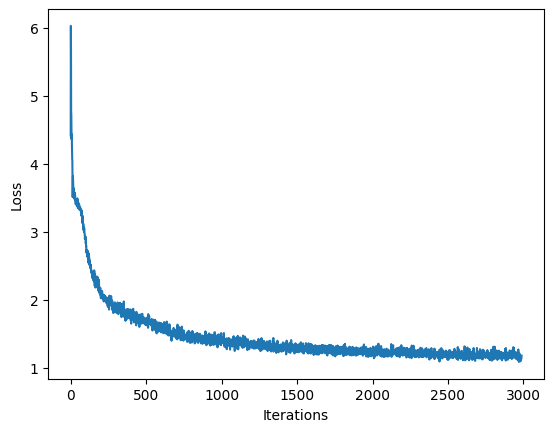

100%|██████████| 3000/3000 [01:58<00:00, 25.30it/s]


True

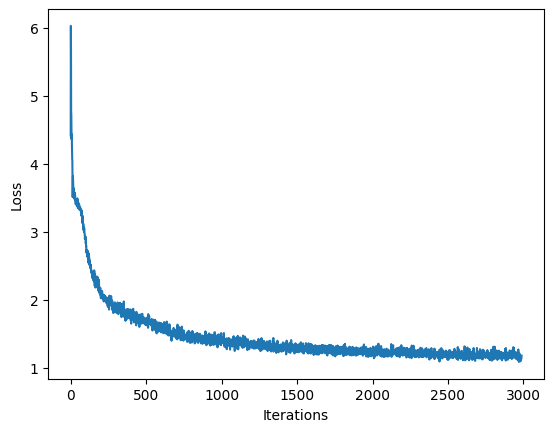

In [ ]:
history = []
experiment = create_experiment(COMET_API_KEY, params)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(params["num_training_iterations"])):
  x_batch, y_batch = get_batch(vectorized, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  experiment.log_metric("loss", loss.numpy().mean(), step=iter)

  history.append(loss.numpy().mean())
  plotter.plot(history)

  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)
experiment.flush()

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(len(unique), params["embedding_dim"], batch_size=1),
  tf.keras.layers.LSTM(
      params["rnn_units"],
      return_sequences=True,
      recurrent_initializer="glorot_uniform",
      recurrent_activation="sigmoid",
      stateful=True),
  tf.keras.layers.Dense(len(unique)),
])

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [ ]:
def generate_text(model, start_string, generation_length=1000):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0) #adding batch dimension making it compatible with the model

  text_generated = []
  model.reset_states() #reset LSTM

  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0) #remove batch dimension
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:08<00:00, 124.58it/s]


In [ ]:
print(generated_text)

XqL:A,|DEF GFE|F2B Adc|d2B cBA|B2A B2d|fed edc|BAB BdB|!
edB GED|D2G F2D|A2e agf|f2ac aced|eae2 fded|cdeB BABc|d2de fdef|defd cdef|gfed d2cd|!
B,DD2 D2CA,|DEDE FEDE|F2D2 D2ED D2A2|!
B2GA B2de|fdd2 edd2|!
B2dB BAA2:|!
F3B BABc|dBB2 e2fe|dBB2 fedc|ede^c d2ef|g3a baaf|defe dBB2|fBB2 eBdg|fefe dcdB|AdcA Bcde|fdef eBB2|BEE2 AFd2|Bdef bege|Bded eaaf|edcd ecAc|B2dB Bdfd|Bdd2 edBA|BABc BAA2:|!
G2BG dEE2:|!
eaa fec|afd e2d|B2B A2E F2D|EB2 ABB cBA|BAA dcA|Bee adf|afd e2e|fdB ^cd|e2 f2 d2|A2 G2 B2|A2 c2 ed|ga e/f/e/d/|B2 e2 f2|!
efe dfe|ae^c d2f|aec Bede|fea2 bgg2|a2bg afaf|gedB BAaB|fd^cA eAcA|dAeA AFD2|DABG AcBA|F2D2 D2:|[2 B|A2 A2 A2|G6-M:C
L:1/8
K:D Major
F:|!

X:5
T:O'Road Runket
Z: id:dc-jig-142
M:6/8
L:1/8
K:Maid
Z: id:dc-jig-60
M:6/8
L:1/8
K:D Major
G|dee BAB|E2c d2:|!
a|b1 f2 B2|ge fa a2|a3 ef e2|a2 f/e/f/e/ ce|fd cA|ef a6|!
ge B2 D2E|EEB,/E/D/B c2B d2:|!

X:47
T:Gance-8
M:6/8
L:1/8
K:E Minor
D2FD CEEE|FDEAD EDdD|E2D2 Dfed|cdef afdg|Baab abaf|e2a2 agbg agaf|edBd eaa2|eaaf afdf|afdd cdef|

In [ ]:
pattern = '(^|\n\n)(.*?)\n\n'
search_results = re.findall(pattern, generated_text, overlapped=True, flags=re.DOTALL)
generated_songs = [song[1] for song in search_results]
print("Found {} songs in text".format(len(songs)))


Found 2 songs in text


In [ ]:
for i, song in enumerate(generated_songs):
  waveform = mdl.lab1.play_song(song)

  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    experiment.log_asset(wav_file_path)

Generated song 1


In [ ]:
experiment.end()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : bright_wildfowl_4247
COMET INFO:     url                   : https://www.comet.com/dod/6s191-lab1-part2/afff5bf42854450ca541a59ec3ec448a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3000] : (1.0897254943847656, 6.02590131